In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
user_name="Veer"
user_id=62
POS_PATH=os.path.join("app","data","positive",f"{user_name}_{user_id}")
NEG_PATH=os.path.join("app","data","negative")
ANC_PATH=os.path.join("app","data","anchor",f"{user_name}_{user_id}")

In [3]:
directories = [POS_PATH,NEG_PATH,ANC_PATH]

In [4]:
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created: {directory}")
    else:
        print(f"Already exists: {directory}")

Already exists: app\data\positive\Veer_62
Already exists: app\data\negative
Already exists: app\data\anchor\Veer_62


In [5]:
dataset='https://www.kaggle.com/datasets/jessicali9530/lfw-dataset?resource=download-directory'

In [13]:
i=0
cap=cv2.VideoCapture(0)
while cap.isOpened():
    res,frame=cap.read()
    frame = cv2.resize(frame, (250, 250))
    if i < 300:
        if i%50==0:
            print("Saving Images")
        if i==299:
            print("Saved All")
        img_name=os.path.join(ANC_PATH,f'Veer_{i}.jpg')
        cv2.imwrite(img_name,frame)
        i+=1
    cv2.imshow("Image",frame)
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Saving Images
Saving Images
Saving Images
Saving Images
Saving Images
Saving Images
Saved All


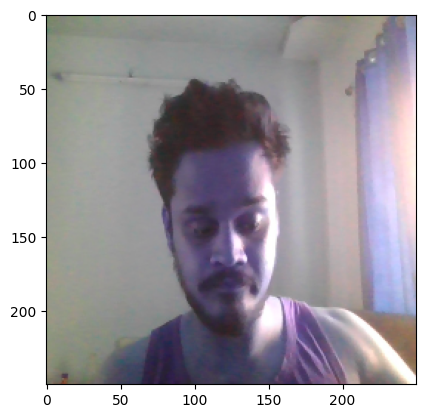

In [14]:
plt.imshow(frame)

In [15]:
frame.shape

(250, 250, 3)

In [5]:
import torch
import os
import random
from PIL import Image

In [6]:
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import transforms

In [7]:
def load_images_from_folder(folder_path, max_images=300):
    image_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.jpg')])[:max_images]
    images = [os.path.join(folder_path, f) for f in image_files]
    return images

In [8]:
def create_siamese_pairs(anchor_paths, positive_paths, negative_paths):
    positive_pairs = list(zip(anchor_paths, positive_paths, [1.0] * len(anchor_paths)))
    negative_pairs = list(zip(anchor_paths, negative_paths[:len(anchor_paths)], [0.0] * len(anchor_paths)))
    all_pairs = positive_pairs + negative_pairs
    random.shuffle(all_pairs)  
    return all_pairs

In [9]:
class SiameseDataset(Dataset):
    def __init__(self,pairs,apply_transforms=True):
        self.pairs=pairs
        self.transforms=transforms.Compose([
            transforms.Resize((105, 105)),
            transforms.ToTensor()
            ]) if apply_transforms else None
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, index):
    
        img_path1,img_path2,label=self.pairs[index]
        img1 = Image.open(img_path1).convert('RGB')
        img2 = Image.open(img_path2).convert('RGB')
        
        if self.transforms:
            img1 = self.transforms(img1)
            img2 = self.transforms(img2)
            
        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [10]:
anchor_paths = load_images_from_folder(ANC_PATH, max_images=300)
positive_paths = load_images_from_folder(POS_PATH, max_images=300)
negative_paths = load_images_from_folder(NEG_PATH, max_images=300)
all_pairs = create_siamese_pairs(anchor_paths, positive_paths, negative_paths)
print(len(all_pairs))  

600


In [11]:
all_pairs[109]

('app\\data\\anchor\\Veer_62\\Veer_189.jpg',
 'app\\data\\negative\\Adrien_Brody_0001.jpg',
 0.0)

In [12]:
split_idx = int(0.7 * len(all_pairs))
train_pairs = all_pairs[:split_idx]
test_pairs = all_pairs[split_idx:]

In [13]:
train_data=SiameseDataset(train_pairs,apply_transforms=True)
test_data=SiameseDataset(test_pairs,apply_transforms=True)

In [14]:
train_data[1]

(tensor([[[0.4275, 0.4431, 0.4549,  ..., 0.6196, 0.6667, 0.6627],
          [0.4314, 0.4549, 0.4667,  ..., 0.6471, 0.6863, 0.6784],
          [0.4353, 0.4549, 0.4745,  ..., 0.6627, 0.7059, 0.6941],
          ...,
          [0.4471, 0.4314, 0.4157,  ..., 0.9569, 0.7412, 0.4353],
          [0.4078, 0.4000, 0.3804,  ..., 0.9686, 0.9216, 0.6118],
          [0.3608, 0.3843, 0.3686,  ..., 0.9686, 0.9725, 0.8314]],
 
         [[0.5451, 0.5294, 0.5176,  ..., 0.5608, 0.5608, 0.5647],
          [0.5412, 0.5333, 0.5255,  ..., 0.5843, 0.5765, 0.5725],
          [0.5333, 0.5333, 0.5255,  ..., 0.5882, 0.5922, 0.5765],
          ...,
          [0.5216, 0.5137, 0.4941,  ..., 0.9882, 0.7882, 0.4941],
          [0.4863, 0.4784, 0.4588,  ..., 0.9961, 0.9529, 0.6510],
          [0.4510, 0.4588, 0.4275,  ..., 1.0000, 0.9922, 0.8510]],
 
         [[0.5137, 0.5020, 0.5137,  ..., 0.5529, 0.5451, 0.5412],
          [0.5137, 0.5059, 0.5137,  ..., 0.5804, 0.5765, 0.5686],
          [0.5020, 0.4980, 0.5020,  ...,

In [15]:
len(train_data)

420

In [16]:
test_data[1]

(tensor([[[0.4392, 0.4588, 0.4549,  ..., 0.6157, 0.6745, 0.6863],
          [0.4471, 0.4667, 0.4627,  ..., 0.6471, 0.6941, 0.6941],
          [0.4471, 0.4627, 0.4667,  ..., 0.6745, 0.7059, 0.6980],
          ...,
          [0.4392, 0.4471, 0.4314,  ..., 0.3137, 0.2745, 0.2706],
          [0.4000, 0.4118, 0.3961,  ..., 0.3608, 0.2902, 0.2745],
          [0.3882, 0.4000, 0.3647,  ..., 0.4784, 0.3216, 0.2902]],
 
         [[0.5529, 0.5373, 0.5333,  ..., 0.5529, 0.5451, 0.5451],
          [0.5412, 0.5294, 0.5294,  ..., 0.5725, 0.5725, 0.5686],
          [0.5294, 0.5255, 0.5255,  ..., 0.5804, 0.5882, 0.5804],
          ...,
          [0.5294, 0.5098, 0.4863,  ..., 0.4157, 0.4039, 0.4039],
          [0.4824, 0.4745, 0.4667,  ..., 0.4510, 0.4078, 0.4000],
          [0.4588, 0.4588, 0.4431,  ..., 0.5412, 0.4196, 0.3961]],
 
         [[0.4431, 0.4784, 0.5059,  ..., 0.5255, 0.5490, 0.5765],
          [0.4549, 0.4824, 0.5098,  ..., 0.5569, 0.5765, 0.5961],
          [0.4627, 0.4863, 0.5059,  ...,

In [17]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data,shuffle=True)

In [18]:
first_batch = next(iter(train_loader))
img1, img2, label = first_batch

In [19]:
print(len(first_batch))
print(img1.shape)  
print(img2.shape)
print(label)   

3
torch.Size([16, 3, 105, 105])
torch.Size([16, 3, 105, 105])
tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.])


In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [35]:
class SiameseNeuralNetwork(nn.Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=10, stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        x = F.relu(self.conv4(x))              
        x = x.view(x.size(0), -1)             
        x = torch.sigmoid(self.fc1(x))         
        return x

In [36]:
class FinalLayer(nn.Module):
    def __init__(self):
        super(FinalLayer,self).__init__()
        self.linear=nn.Linear(4096,1)
    
    def forward(self,x):
        x=torch.sigmoid(self.linear(x))
        return x

In [37]:
def compute_l1_distance(anchor_embeddings,validation_embeddings):
    l1_distance = torch.abs(anchor_embeddings - validation_embeddings)
    return l1_distance

In [38]:
print(torch.cuda.is_available())

True


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
first_batch = next(iter(train_loader))
print((first_batch[1]))

tensor([[[[0.4824, 0.4824, 0.4902,  ..., 0.6471, 0.6941, 0.7098],
          [0.4824, 0.4863, 0.4902,  ..., 0.6863, 0.7255, 0.7216],
          [0.4980, 0.4941, 0.4863,  ..., 0.7176, 0.7490, 0.7255],
          ...,
          [0.4627, 0.4510, 0.4275,  ..., 0.3059, 0.3059, 0.3176],
          [0.4235, 0.4235, 0.4118,  ..., 0.3333, 0.3098, 0.3137],
          [0.4078, 0.4235, 0.4157,  ..., 0.3608, 0.3137, 0.2980]],

         [[0.5373, 0.5412, 0.5569,  ..., 0.5686, 0.5765, 0.5804],
          [0.5294, 0.5412, 0.5569,  ..., 0.5882, 0.5961, 0.5922],
          [0.5333, 0.5451, 0.5569,  ..., 0.6000, 0.6039, 0.6000],
          ...,
          [0.5647, 0.5451, 0.5176,  ..., 0.4196, 0.4039, 0.4157],
          [0.5137, 0.5059, 0.4824,  ..., 0.4353, 0.4118, 0.4157],
          [0.4824, 0.4941, 0.4549,  ..., 0.4510, 0.4039, 0.4078]],

         [[0.4745, 0.4784, 0.4941,  ..., 0.5686, 0.5608, 0.5451],
          [0.4863, 0.4941, 0.5059,  ..., 0.5922, 0.5804, 0.5529],
          [0.5098, 0.5098, 0.5137,  ..., 0

In [41]:
embedding_model = SiameseNeuralNetwork()
final_layer = FinalLayer()

In [42]:
embedding_model.to(device)

SiameseNeuralNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
)

In [43]:
final_layer.to(device)

FinalLayer(
  (linear): Linear(in_features=4096, out_features=1, bias=True)
)

In [44]:
optimizer = torch.optim.Adam(list(embedding_model.parameters()) + list(final_layer.parameters()), lr=1e-4)
criterion = nn.BCELoss()

In [45]:
for img1, img2, label in train_loader:
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)
    print(img1)
    print(len(img1))
    print(img1.shape)
    
    # print(img2)
    # print(label)
    break

tensor([[[[0.4510, 0.4706, 0.4667,  ..., 0.6157, 0.6627, 0.6706],
          [0.4431, 0.4549, 0.4549,  ..., 0.6431, 0.6824, 0.6863],
          [0.4392, 0.4431, 0.4471,  ..., 0.6588, 0.6980, 0.6941],
          ...,
          [0.4510, 0.4275, 0.4196,  ..., 0.9373, 0.9686, 0.9725],
          [0.3922, 0.3725, 0.3725,  ..., 0.8510, 0.9569, 0.9765],
          [0.3882, 0.3765, 0.3490,  ..., 0.7294, 0.9176, 0.9765]],

         [[0.5451, 0.5216, 0.5176,  ..., 0.5490, 0.5569, 0.5608],
          [0.5294, 0.5255, 0.5255,  ..., 0.5843, 0.5804, 0.5765],
          [0.5137, 0.5216, 0.5373,  ..., 0.5882, 0.5922, 0.5804],
          ...,
          [0.5294, 0.5255, 0.5020,  ..., 0.9843, 1.0000, 1.0000],
          [0.4863, 0.4824, 0.4706,  ..., 0.9137, 0.9961, 1.0000],
          [0.4510, 0.4627, 0.4353,  ..., 0.8000, 0.9686, 1.0000]],

         [[0.4745, 0.4784, 0.4980,  ..., 0.5490, 0.5373, 0.5255],
          [0.5020, 0.4902, 0.4863,  ..., 0.5725, 0.5451, 0.5255],
          [0.5216, 0.4980, 0.4824,  ..., 0

In [46]:
epochs=22
for epoch in range(epochs):
    embedding_model.train()
    final_layer.train()
    total_loss = 0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        anchor_out = embedding_model(img1)      
        paired_out = embedding_model(img2)      
        distance = compute_l1_distance(anchor_out, paired_out) 

        pred = final_layer(distance).squeeze() 
        loss = criterion(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/22, Loss: 9.1343
Epoch 2/22, Loss: 1.5415
Epoch 3/22, Loss: 1.4369
Epoch 4/22, Loss: 0.6093
Epoch 5/22, Loss: 0.2855
Epoch 6/22, Loss: 0.1702
Epoch 7/22, Loss: 0.1047
Epoch 8/22, Loss: 0.0805
Epoch 9/22, Loss: 0.0530
Epoch 10/22, Loss: 0.0332
Epoch 11/22, Loss: 0.0415
Epoch 12/22, Loss: 0.0266
Epoch 13/22, Loss: 0.0195
Epoch 14/22, Loss: 0.0131
Epoch 15/22, Loss: 0.0116
Epoch 16/22, Loss: 0.0124
Epoch 17/22, Loss: 0.0097
Epoch 18/22, Loss: 0.0111
Epoch 19/22, Loss: 0.0153
Epoch 20/22, Loss: 0.0274
Epoch 21/22, Loss: 0.0126
Epoch 22/22, Loss: 0.0068


In [49]:
embedding_model.eval()
final_layer.eval()
total_test_loss = 0

with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        anchor_out = embedding_model(img1)
        paired_out = embedding_model(img2)
        distance = compute_l1_distance(anchor_out, paired_out)
        pred = final_layer(distance).squeeze()
        loss = criterion(pred.view(-1), label.view(-1))
        total_test_loss += loss.item()

print(f"Test Loss: {total_test_loss:.4f}")


Test Loss: 0.0410


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(embedding_model, final_layer, test_loader, device):
    embedding_model.eval()
    final_layer.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            # print(img1.shape)
            anchor_out = embedding_model(img1)
            paired_out = embedding_model(img2)
            distance = compute_l1_distance(anchor_out, paired_out)
            pred = final_layer(distance).squeeze()  
            predicted_labels = (pred >= 0.5).float()  
            all_labels.extend(label.cpu().numpy().tolist())  
            all_preds.extend(predicted_labels.cpu().numpy().reshape(-1).tolist())  
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
evaluate_model(embedding_model, final_layer, test_loader, device)


Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [80]:
for img1,img2,label in test_loader:
    print(img1.shape)
    break

torch.Size([1, 3, 105, 105])


In [113]:
transform_image = transforms.Compose([
    transforms.Resize((105, 105)),  
    transforms.ToTensor()
])

In [ ]:
import os
import shutil
import random

def load_images_from_for_verification(folder_path, num_images=62):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    random.shuffle(image_files) 
    selected_images = image_files[:num_images] 
    images = [os.path.join(folder_path, f) for f in selected_images] 
    return images

def create_verification_data(images, verification_path):
    os.makedirs(verification_path, exist_ok=True)  
    for image in images:
        src = image  
        dst = os.path.join(verification_path, os.path.basename(image)) 
        shutil.copy(src, dst)
    print(f"Copied {len(images)} images to {verification_path}")
verfication_path = os.path.join("app", "application_data", "verification", f"{user_name}_{user_id}")
create_verification_data(load_images_from_for_verification(POS_PATH), verfication_path)

Copied 62 images to app\application_data\verification\Veer_62


In [122]:
def preprocess(path):
    img = Image.open(path).convert('RGB')
    img = transform_image(img)
    return img.view(1, 3, 105, 105).to(device)

In [127]:
import numpy as np
def verify_face(detection_threshold=0.5,verification_threshold=0.5):
    results=[]
    for image in os.listdir(os.path.join('app','application_data','verification',f'{user_name}_{user_id}')):
        input_image=preprocess(os.path.join('app','application_data','input','input_image.jpg'))
        verification_image=preprocess(os.path.join('app','application_data','verification',f'{user_name}_{user_id}',image))
        input=embedding_model(input_image)
        # print(input.shape)
        verification=embedding_model(verification_image)
        # print(verification.shape)
        distance = compute_l1_distance(input, verification)
        pred = final_layer(distance).squeeze()  
        results.append(pred)
    
    results=[pred.item() for pred in results]
    detection=np.sum(np.array(results)>detection_threshold)
    verification=detection/62
    verified=verification > verification_threshold
    return results,verified
    
results,verified=verify_face()
print(results)
print(verified)

[0.9999998807907104, 0.9999998807907104, 0.9998824596405029, 0.9999228715896606, 0.9999228715896606, 0.9999105930328369, 0.9947277903556824, 0.9635593295097351, 0.9960026144981384, 0.9999998807907104, 0.9999264478683472, 0.9999493360519409, 0.9999998807907104, 0.9991084933280945, 0.9987165927886963, 0.9999998807907104, 0.9999792575836182, 0.9999808073043823, 0.9999866485595703, 0.9999830722808838, 0.9999698400497437, 0.9999295473098755, 0.999883770942688, 0.9999356269836426, 0.999998927116394, 0.9999977350234985, 0.9999804496765137, 0.9999929666519165, 0.9999945163726807, 0.9999902248382568, 0.9996813535690308, 0.9992985725402832, 0.9989407658576965, 0.9979552030563354, 0.9973058700561523, 0.9961418509483337, 0.999984622001648, 0.9999998807907104, 0.9999942779541016, 0.9999974966049194, 0.9999992847442627, 0.9999991655349731, 0.9999991655349731, 0.9999990463256836, 0.9999990463256836, 0.9999998807907104, 0.9999997615814209, 0.9999995231628418, 0.9999788999557495, 0.9998327493667603, 0.

In [110]:
i=0
verify=1
cap=cv2.VideoCapture(0)
while cap.isOpened():
    res,frame=cap.read()
    frame = cv2.resize(frame, (250, 250))
    cv2.imshow("Image",frame)
    # if verify==1:
    #     cv2.imwrite(os.path.join('app','application_data','input','input_image.jpg'),frame)
    #     results,verified=verify_face()
    #     print(results)
    if cv2.waitKey(1) & 0XFF==ord('a'):
        cv2.imwrite(os.path.join('app','application_data','input','input_image.jpg'),frame)
        preprocess()
        break
    if cv2.waitKey(1) & 0XFF==ord('q'):qq
        break
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [111]:
cap.release()
cv2.destroyAllWindows()